# Reproduction and Validation of a Scientific Paper
This Notebook presents the workflow and results of the exercise of the Experiment Design for Data Science course at TU Vienna. During this exercise the results of the paper "Carousel Personalization in Music Streaming Apps with Contextual Bandits" by by Benada et al. were reproduced and validated. The detailed description of the process and interpretations can be found in the accompanying report, which was released together with this report. 


In [1]:
# installations of required libraries
!pip install numpy
!pip install pandas
!pip install scipy

In [17]:
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
sns.set_style(style='darkgrid')
plt.style.use('seaborn-darkgrid')

from scipy import stats
from scipy.stats import norm
from scipy.stats import mannwhitneyu

from environment import ContextualEnvironment
from policies import KLUCBSegmentPolicy, RandomPolicy, ExploreThenCommitSegmentPolicy, EpsilonGreedySegmentPolicy, TSSegmentPolicy, LinearTSPolicy
import time
from main import *


In [11]:
# Helper Functions for statistical evaluation

def print_decision(pvalue, alpha):
    print("Test Result:")
    print("p-value = %.4f" % (pvalue))
    if pvalue < alpha:
        print("H0 can be rejected on a level of significance of " + str(alpha) + ".")
    else:
        print("H0 cannot be rejected on a level of significance of " + str(alpha) + ".")
        
def compute_pvalue(pvalue, diff, alternative):
    if alternative == "greater":
        if diff > 0:
            pvalue = pvalue / 2
        else:
            pvalue = 1 - pvalue / 2
    elif alternative == "less":
        if diff < 0:
            pvalue = pvalue / 2
        else:
            pvalue = 1 - pvalue / 2
    return pvalue

def plot_hist(data, group):
    # Plot a histogram
    plt.hist(data, density = True, alpha = 0.5)

    # Fit a normal distribution to the data
    mu, std = norm.fit(data)

    # Plot the probability density function
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 201)
    y = norm.pdf(x, mu, std)
    plt.plot(x, y, "black")
    title = "Fit results of " + group + ": mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)


# Reproduction
Overall the paper release their code and their data in a public repository: https://github.com/deezer/carousel_bandits  The paper consits of an offline and online experiment. There was no way for us to reproduce the offline experiment. Thus we focused our effort on the offline experiments. The paper in itself doesn't show many results. The major one being that a certain algorithm of the multiarmed bandit outperforms all the other ones, which were tested. 

## Shoing that the provided Code runs
The following chunk runs a lightweight version of the experiment once, with only a handful of users.
At each round, the model gets fitted to every user in the dataset and a regret score is calculated.
At the end of all rounds (by default 100 rounds) the minimum cumulative regret indicates, which model performs best.
According to the source paper, *ts-seg-pessimistic* performs best on the offline experiment. Hence, they tested this models performance in a cascade versus non-cascade offline experiment, in which case the *ts-seg-pessimistic cascade* model performed best. This model also caused the highest display-to-stream gain.
All featured tests' results showed statistical significance at the 1% level. However, the paper does not state how those statistical tests were conducted.

In [ ]:
# small dataset, all policies
# !python main.py --users_path data/user_features_small.csv --policies random,etc-seg-explore,etc-seg-exploit,epsilon-greedy-explore,epsilon-greedy-exploit,kl-ucb-seg,ts-seg-naive,ts-seg-pessimistic,ts-lin-naive,ts-lin-pessimistic --n_users_per_round 9 --output_path general_experiment_results.json
# !python plot_results.py --data_path general_experiment_results.json


In [ ]:
# full dataset, two policies
# !python main.py --policies random,ts-seg-pessimistic --print_every 5 --output_path general_experiment_results.json
# !python plot_results.py --data_path general_experiment_results.json

## Issues

One major issue with the provided code which was found is that in each round the algorithm is trained on 20000 randomly selected users. Thus, depending on what users each algorithm sees in what round it should have lead to different regret values. The paper doesn't set a seed for the sampling, which is understanble as it would lead to always the same sampling of users and not take advantage of the whole dataset. This is the major issue with the methodolgy, which will be explored in this notebook.

## Reproduction on the Whole Dataset
To visulalize and explore the variability of the workflow introduced by the user selection we repeated the whole offline experiment 5 seperate times and stored the corresponding results. It has to be noted at this point that running the training of all policies on the whole dataset (still with 20000 useres per round) takes approximatley 5 hours on our machine. Thus we were satisfied by having a sample size of 5.


In [14]:
# experiment setup
users_path = "data/user_features.csv"
users_df = pd.read_csv(users_path)

playlists_path = "data/playlist_features.csv"
playlists_df = pd.read_csv(playlists_path)

n_users = len(users_df)
n_playlists = len(playlists_df)
n_recos = 12
print_every = 10

user_features = np.array(users_df.drop(["segment"], axis = 1))
user_features = np.concatenate([user_features, np.ones((n_users,1))], axis = 1)
playlist_features = np.array(playlists_df)

user_segment = np.array(users_df.segment)

policies_name = "random,etc-seg-explore,etc-seg-exploit,epsilon-greedy-explore,epsilon-greedy-exploit,kl-ucb-seg,ts-seg-naive,ts-seg-pessimistic,ts-lin-naive,ts-lin-pessimistic".split(",")
policies = set_policies(policies_name, user_segment, user_features, n_playlists)
n_policies = len(policies)

n_users_per_round = 20000
n_rounds = 100
overall_rewards = np.zeros((n_policies, n_rounds))
overall_optimal_reward = np.zeros(n_rounds)

l_init = 3
n_recos = 12


/Users/christophbartmann/Library/Mobile Documents/com~apple~CloudDocs/New Macbook/Data Science/Design of Experiment/Exercise 2/carousel_reproduction/online_logistic_regression.py:26: RuntimeWarning: invalid value encountered in reciprocal
  self.w = np.random.normal(self.m, self.alpha * (self.q)**(-1.0), size = self.n_dim)


In [ ]:
#running this junk will approximately take 30 hours
for k in range(5):
    print("Run: %d"%(k))
    cont_env = ContextualEnvironment(user_features, playlist_features, user_segment, n_recos)    
    start_time = time.time()
    for i in range(n_rounds):
        # Select batch of n_users_per_round users
        user_ids = np.random.choice(range(n_users), n_users_per_round)
        overall_optimal_reward[i] = np.take(cont_env.th_rewards, user_ids).sum()
        # Iterate over all policies
        for j in range(n_policies):
            # Compute n_recos recommendations
            recos = policies[j].recommend_to_users_batch(user_ids, n_recos, l_init)
            # Compute rewards
            rewards = cont_env.simulate_batch_users_reward(batch_user_ids= user_ids, batch_recos=recos)
            # Update policy based on rewards
            policies[j].update_policy(user_ids, recos, rewards, l_init)
            overall_rewards[j,i] = rewards.sum()
        # Print info
        if i == 0 or (i+1) % print_every == 0 or i+1 == n_rounds:
            print("Round: %d/%d. Elapsed time: %f sec." % (i+1, n_rounds, time.time() - start_time))

    output_path = 'reproducibility_exp/completly_new/results_%d.json'%(k)
    print("Saving cumulative regrets in %s" % output_path)
    cumulative_regrets = {policies_name[j] : list(np.cumsum(overall_optimal_reward - overall_rewards[j])) for j in range(n_policies)}
    with open(output_path, 'w') as fp:
        json.dump(cumulative_regrets, fp)

In [15]:
# Processing the reulst for the experiments
all ={}
mean ={}
std = {}
last_round ={}
data_path = 'reproducibility_exp/completly_new/results_0.json'

with open(data_path, 'r') as fp:
    cumulative_regrets = json.load(fp)
for k,v in cumulative_regrets.items():
    all[k] = list()
    mean[k] = list()
    std[k] = list()
    last_round[k] = list()

for k in range(5):
    output_path = 'reproducibility_exp/completly_new/results_%d.json'%(k)
    #if k!=2:
    with open(output_path, 'r') as fp:
        cumulative_regrets = json.load(fp)
        for k,v in cumulative_regrets.items():
            all[k].append(np.array(v))


In [16]:
for i in all.keys():
    for j in range(len(all[i][0])):
        intermediate = list()
        for k in range(len(all[i])):
            intermediate.append(all[i][k][j])

        mean[i].append(np.mean(intermediate))
        std[i].append(np.std(intermediate))

for i in all.keys():
    for j in range(len(all[i])):
        last_round[i].append(all[i][j][-1])

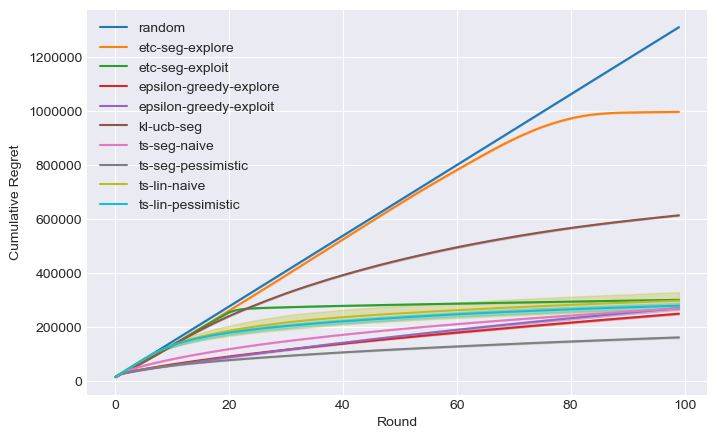

In [20]:
# Visulaizing the Cumulative Results
pos_col = mcolors.TABLEAU_COLORS.keys()

fig, ax = plt.subplots(figsize=(8,5))
for i in range(len(mean.keys())):
    sns.lineplot(data = np.array(mean[list(mean.keys())[i]]), label = list(mean.keys())[i], color=list(pos_col)[i])
    plt.fill_between(range(len(mean[list(mean.keys())[i]])), np.array(mean[list(mean.keys())[i]])-np.array(std[list(mean.keys())[i]]), np.array(mean[list(mean.keys())[i]])+np.array(std[list(mean.keys())[i]]), alpha =0.30, color=list(pos_col)[i])
ax.ticklabel_format(style='plain')
plt.xlabel("Round")
plt.ylabel("Cumulative Regret")
plt.show()

The plot above shows the obtained results. The line represent the mean regret obtained over the five itereations and the variablity is shown as filled space around the mean according to the standard deviation. One fairly obvious conclusion is that the illustration looks almost identical to the original graphic in the paper. Additionally we seee that in almost all algorihtms are fairly robust with regards to the users it is trained on. Maybe this is because of the large sample size in each round and the default value taken in the paper represents a hypertuned one, which balances well the robustness and computational performance. Only the 'ts-lin-naive' approach seems to show visible variablilty. In all other cases the standard deviation too small to be visible on the presenetd scale.

### Statistical Testing

The conclusion from the paper is that the 'ts-seg-pessimistic' policy outperforms all other ones and says it does so with a siginificance niveau of 0.01. However, they don't specify the test they use or what data they used for the test. Thus we further explored the results using different statistical tests and different data. More specifically for the test statistic either the whole data of all 5 iterations was used or simply the information in the last round as this resembles the final model, which will be used in production.

Since we have a relative small sample size we stuck with non-parametric tests and in a first step used a Friedman test to confirm that at least one location parameter all policies is different to all others. This procedure was prefered to use a two-sample test on all possible combinations as it limits the probailiy of a type 1 error. The Friedman test is a non-parametric test alternative to the repeaeted ANOVA test. It uses the following hypothesis, with n being at least 3:

$H_0: \mu_1 = \mu_2 = ... = \mu_n$


$H_1: \exists i,j \leq n: \mu_i \neq \mu_j$ 


In [52]:
friedmann_df = pd.DataFrame(columns=['p-Value'], index=['All', 'Last Round'])

In [54]:
# Friedman Test on the whole training data 
alpha = 0.01
res = stats.friedmanchisquare(all[policies_name[0]], all[policies_name[1]], all[policies_name[2]], all[policies_name[3]], all[policies_name[4]], all[policies_name[5]], all[policies_name[6]], all[policies_name[7]], all[policies_name[8]], all[policies_name[9]])
print_decision(res.pvalue, alpha)

friedmann_df['p-Value']['All']=res.pvalue

Test Result:
p-value = 0.0000
H0 can be rejected on a level of significance of 0.01.


In [56]:
#using only the data from the last round
res = stats.friedmanchisquare(last_round[policies_name[0]], last_round[policies_name[1]], last_round[policies_name[2]], last_round[policies_name[3]], last_round[policies_name[4]], last_round[policies_name[5]], last_round[policies_name[6]], last_round[policies_name[7]], last_round[policies_name[8]], last_round[policies_name[9]])
print_decision(res.pvalue, alpha)

friedmann_df['p-Value']['Last Round']=res.pvalue

Test Result:
p-value = 0.0000
H0 can be rejected on a level of significance of 0.01.


To no suprise in both cases we can frimly reject the null hypothesis, which shows us that there is a significant difference in the results of the policies. Since, the paper claims that the policy 'ts-seg-pessimistic' is significantly better than all other ones, we performed statistical tests to confirm that. We used a Mann-Whitney-U test, since we compare the distributions of independent samples. In order to confirm the statemant that the policy is truly better than all other ones we perform a one sided test with the follwing Hypothesis:

$H_0: \mu_A \geq \mu_B$ 

$H_1: \mu_A < \mu_B$ (```alternative = "less"```)

Thus in the case the assumption of the paper is correct we can always reject the null hypothesis.

In [80]:
iterables = [["All", "Last Round"], policies_name]
m_index = pd.MultiIndex.from_product(iterables, names=["Data", "Policy"])

mwu_df = pd.DataFrame(columns=['p-Value'], index = m_index)
mwu_df.drop('ts-seg-pessimistic', level=1, inplace=True)

In [81]:
#on all the data
for i in policies_name:
    if i != 'ts-seg-pessimistic':
        res = stats.mannwhitneyu(np.array(all['ts-seg-pessimistic']).flatten(), np.array(all[i]).flatten(), alternative = 'less')
        mwu_df.loc[('All',i)]=res.pvalue
        if res.pvalue > alpha:
            print_decision(res.pvalue, alpha)
        else:
            print("Comparing ts-seg-pessimistic to %s result: H0 rejected"%(i))


Comparing ts-seg-pessimistic to random result: H0 rejected
Comparing ts-seg-pessimistic to etc-seg-explore result: H0 rejected
Comparing ts-seg-pessimistic to etc-seg-exploit result: H0 rejected
Comparing ts-seg-pessimistic to epsilon-greedy-explore result: H0 rejected
Comparing ts-seg-pessimistic to epsilon-greedy-exploit result: H0 rejected
Comparing ts-seg-pessimistic to kl-ucb-seg result: H0 rejected
Comparing ts-seg-pessimistic to ts-seg-naive result: H0 rejected
Comparing ts-seg-pessimistic to ts-lin-naive result: H0 rejected
Comparing ts-seg-pessimistic to ts-lin-pessimistic result: H0 rejected


In [82]:
#on just the last round
for i in policies_name:
    if i != 'ts-seg-pessimistic':
        res = stats.mannwhitneyu(last_round['ts-seg-pessimistic'], last_round[i], alternative = 'less')
        mwu_df.loc[('Last Round',i)]=res.pvalue
        
        if res.pvalue > alpha:
            print_decision(res.pvalue, alpha)
        else:
            print("Comparing ts-seg-pessimistic to %s result: H0 rejected"%(i))
        

Comparing ts-seg-pessimistic to random result: H0 rejected
Comparing ts-seg-pessimistic to etc-seg-explore result: H0 rejected
Comparing ts-seg-pessimistic to etc-seg-exploit result: H0 rejected
Comparing ts-seg-pessimistic to epsilon-greedy-explore result: H0 rejected
Comparing ts-seg-pessimistic to epsilon-greedy-exploit result: H0 rejected
Comparing ts-seg-pessimistic to kl-ucb-seg result: H0 rejected
Comparing ts-seg-pessimistic to ts-seg-naive result: H0 rejected
Comparing ts-seg-pessimistic to ts-lin-naive result: H0 rejected
Comparing ts-seg-pessimistic to ts-lin-pessimistic result: H0 rejected


In [85]:
mwu_df

p-Value
Data       Policy                          
All        random                       0.0
           etc-seg-explore              0.0
           etc-seg-exploit              0.0
           epsilon-greedy-explore       0.0
           epsilon-greedy-exploit       0.0
           kl-ucb-seg                   0.0
           ts-seg-naive                 0.0
           ts-lin-naive                 0.0
           ts-lin-pessimistic           0.0
Last Round random                  0.003968
           etc-seg-explore         0.003968
           etc-seg-exploit         0.003968
           epsilon-greedy-explore  0.003968
           epsilon-greedy-exploit  0.003968
           kl-ucb-seg              0.003968
           ts-seg-naive            0.003968
           ts-lin-naive            0.003968
           ts-lin-pessimistic      0.003968

In both cases the H0 hypothesis is rejected which statistically confirms the claims of the paper.

# My suggestion for reproducing tests
We can reproduce the full offline experiment. We just need to find a way to compare results.
https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/
According to this paper, it is common to do a 10-fold cross validation on the dataset at hand and grab the mean/median success metric of each model as a statistic for that model. We would then have the following hypotheses:
 * h0: there is no difference in model performances, i.e. ts-seg-pessimistic (cascade) performs just as well as the other models, i.e. the lower cumulative regret of the tests are due to chance
  * h1: there is a difference in model performances, i.e. ts-seg-pessimistic (cascade) outperforms the other models

### Does the original code cross-validate?
No, but something different. The argument *n_users_per_round* (default 20.000, 1% of full dataset) states, how many users actually get recommended anything in any round. That means that the actual dataset never changes for every time you run the experiment, but the sample on which you fit and evaluate the model changes on every round.
According to Brownlee (2018, https://machinelearningmastery.com/statistical-significance-tests-for-comparing-machine-learning-algorithms/), this testing behaviour violates a key assumption of the Student's t-test, which is independency of observations in each sample per round.
My suggestion for fixing this. Run the full experiment k (10) times and give the program either 10% of the data to work on, while either continuing to let it use a sample of 20.000 users or even telling it not to resample anything, but rather work on the whole data. Instead of rewriting the source code to include cross-validation, I will split the users dataset itself into k samples and run the whole main.py file k times, with different arguments each time, i.e. changing the results-output-filename.
The only rewriting I will do, is putting the main workflow of the main.py file into a separate main() function with arguments passed in python rather than from the command line, so I can execute it using this notebook.


In [ ]:
from experiment import run_experiment

# test run of the new experiment.py
run_exemplary_experiment = False

if run_exemplary_experiment:
        run_experiment(
                users_path="data/user_features.csv",
                playlists_path="data/playlist_features.csv",
                output_path="results.json",
                policies="random,ts-seg-naive",
                n_recos=12,
                l_init=3,
                n_users_per_round=20000,
                n_rounds=100,
                print_every=10,
        )

In [ ]:
def split_dataset(data_filename, k):
        # grabs a datafile from the folder "data/"
        # randomly splits the dataset into k smaller sets of equal size
        # saves them in the folder "data/split/"

        with open(f"data/{data_filename}", "r") as f:
                full = np.array(f.readlines())

        data_filename, suffix = data_filename.split(".")

        # header row should be separate
        header_row, full = full[0], full[0:]

        N = len(full) # number of all rows
        indices = np.array(list((range(N)))) # numbers from 0 to N
        n = N // k # number of rows per k

        print(f"Splitting {N} rows from {data_filename}.{suffix} into {k} files with {n} rows each ...")

        for i in range(k):
                # get random row numbers from 0 to the length of indices (starts at N)
                random_indices = np.random.choice(len(indices), n, replace=False)
                # grab random row numbers of the remaining ones
                sample_indices = indices[random_indices]
                # remove the selected row numbers from the indices list
                indices = np.delete(indices, random_indices)
                # create a sample
                sample = full[sample_indices]
                # add the header row
                sample = np.append(header_row, sample)
                # save the sample
                print(f"\t saving file number {i}: {sample_indices}")
                f = f"data/split/{data_filename}_{i}.{suffix}"
                with open(f, "w") as f:
                        f.writelines(list(sample))


        print(f"All done. {len(indices)} users remain unsaved: {indices}")
        print()
        del full
        del indices
        del sample




# Preparing k datasets
data_filename = "user_features.csv"
data_filename = "user_features_s.csv"

k = 10

#split_dataset(data_filename, k)

### Data for testing
* data/split/: small data
* data/splitL: big data

In [ ]:
from experiment import run_experiment
all_policies = "random,etc-seg-explore,etc-seg-exploit,epsilon-greedy-explore,epsilon-greedy-exploit,kl-ucb-seg,ts-seg-naive,ts-seg-pessimistic,ts-lin-naive,ts-lin-pessimistic"

def run_k_experiments(
        input_samples_dir,
        output_dir="output",
        n_users_per_round=None,
        print_every=5,
        policies=all_policies
):
        input_samples_dir = input_samples_dir.strip("/")
        output_dir = output_dir.strip("/")

        files = os.listdir(input_samples_dir)
        print(f"Running {len(files)} experiments with input files from {input_samples_dir}")
        for f in files:
                try:
                        run_experiment(
                                users_path=f"{input_samples_dir}/{f}",
                                playlists_path="data/playlist_features.csv",
                                output_path=f"{output_dir}/results_{f}.json",
                                policies=policies,
                                n_recos=12,
                                l_init=3,
                                n_users_per_round=n_users_per_round,
                                n_rounds=100,
                                print_every=print_every,
                        )
                except TypeError as e:
                        print(f"Experiment failed on input file {f}", e)
                except KeyError as e:
                        print(f"Experiment failed on input file {f}", e)
        print("Experiments finished.")


## Experiment 1
Running all policies on all users and seeing which policy performs best
We run this on 10 samples of the original data

In [ ]:
# run the experiment with all policies & all users on each round
# then we can compare the policies' accuracies

input_samples_dir = "data/split"
output_dir = "data/t"
n_users_per_round = None

run_k_experiments(input_samples_dir, output_dir, n_users_per_round)

### Results of experiment 1
- 8 samples with ~1000 users each
- all policies

In [ ]:
## Loading results (cumulative regret)
def get_results(results_location, wide_to_long=False):
        results = None
        for f in [f for f in os.listdir(results_location) if "store" not in f.lower()]:
                with open(f"{results_location}/{f}", "r") as f:
                        res = json.load(f)
                res = {key: [value[-1]] for key, value in res.items()}
                res = pd.DataFrame.from_dict(res)
                if results is None:
                        results = res
                else:
                        results = results.append(res)

        results = results.reset_index().drop("index", 1)

        if wide_to_long:
                results = results.unstack().reset_index()
                results = results.drop("level_1", 1)
                results.columns = ["policy", "regret"]

        return results


In [ ]:
results_location = "output/s1"
experiment_results = get_results(results_location, wide_to_long=True)
experiment_results.sample(10)

In [ ]:
experiment_results.regret.plot(kind='hist', title='Distribution of cumulative regret')
results_mean = experiment_results.groupby("policy").mean().sort_values("regret")
print(results_mean)

In [ ]:
top_policy = results_mean.iloc[0]
global_mean = results_mean.mean()

print("Best performing policy:", top_policy.name)
print("Best performing policy mean:", top_policy[0])
print("Global mean regret:", global_mean[0])


In [ ]:
def test_mean_mann(data, target_policy):

        target_sample = data[data.policy == target_policy].regret
        rest_sample = data[data.policy != target_policy].regret

        global_mean = data[data.policy != target_policy].regret.mean()
        target_mean = data[data.policy == target_policy].regret.mean()

        smaller = global_mean < target_mean
        print("Global mean\t", "<" if smaller else ">", "\tTarget mean")
        print(round(global_mean, 2), "\t", "<" if smaller else ">",  "\t", round(target_mean, 2))



        stat, p = mannwhitneyu(target_sample, rest_sample)
        print(f"p-value: {p}")
        alpha = .05
        significant = p < alpha
        print("—>", "reject H0" if significant else "accept h=")
        print("—>", f"the target policy has a different distribution from the others"
                        if significant
                        else "the target policy has the same distribution as the others")


        fig = plt.figure()
        ax = fig.add_subplot()

        data.regret.plot(kind='hist', title='Population distribution')
        plt.axvline(target_mean, color="yellow")
        ax.set_xlabel(f"Test result {'not' if not significant else ''}significant at significance level of p < {alpha}")


In [ ]:

target_policy = "ts-seg-pessimistic"
data = experiment_results

test_mean_mann(data, target_policy)

## Experiment 2
Finding out whether cascading makes the models better

Original command:
`python main.py --policies epsilon-greedy-explore,epsilon-greedy-explore-no-cascade,ts-seg-pessimistic,ts-seg-pessimistic-no-cascade --print_every 5 --output_path cascade_experiment_results.json`
`python plot_results.py --data_path cascade_experiment_results.json`

In [ ]:
input_samples_dir = "data/split"
output_dir = "output/casc"
n_users_per_round = None
policies = "epsilon-greedy-explore,epsilon-greedy-explore-no-cascade,ts-seg-pessimistic,ts-seg-pessimistic-no-cascade"

run_k_experiments(input_samples_dir, output_dir, n_users_per_round, policies=policies)


In [ ]:
results_location = "output/casc"
experiment_results = get_results(results_location, wide_to_long=True)
experiment_results.sample(10)

In [ ]:
experiment_results.regret.plot(kind='hist', title='Distribution of cumulative regret')
results_mean = experiment_results.groupby("policy").mean().sort_values("regret")
print(results_mean)


In [ ]:

top_policy = results_mean.iloc[0]
global_mean = results_mean.mean()

print("Best performing policy:", top_policy.name)
print("Best performing policy mean:", top_policy[0])
print("Global mean regret:", global_mean[0])


In [ ]:

target_policy = "ts-seg-pessimistic"
data = experiment_results

test_mean_mann(data, target_policy)